# Goal: predict the evaluation of various cars using KNN

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn
import seaborn as sb
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

In [3]:
df = pd.read_csv('car.data')
df.head()

,buying,maint,dcor,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


## Preprocessing
-  get these categorical features inro numerical values

In [4]:
le = preprocessing.LabelEncoder()



for series_name, series in df.items():
    df[series_name] = le.fit_transform(series)
    
df.head()

,buying,maint,dcor,persons,lug_boot,safety,class
0,3,3,0,0,2,1,2
1,3,3,0,0,2,2,2
2,3,3,0,0,2,0,2
3,3,3,0,0,1,1,2
4,3,3,0,0,1,2,2


## Splitting the data intp training and testing data

In [5]:
Y = df['class']
X = df.drop('class', axis=1)
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.1, shuffle=True)

## Hyperparameter tuning n_neighbors

Text(0.5, 0, 'Number of neighbors')

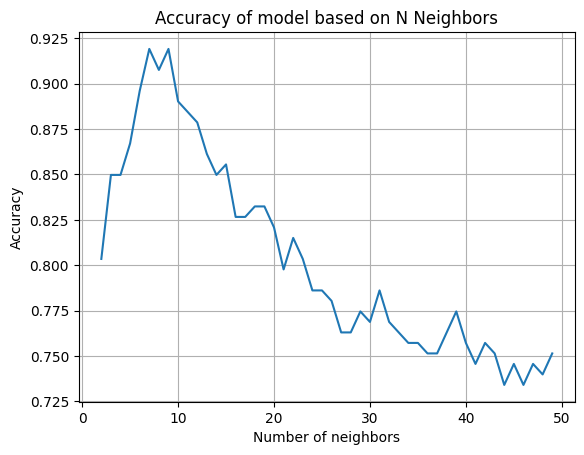

In [6]:
testing_accs = {}
range = np.arange(2, 50, 1)
for n in range:
    knn = KNeighborsClassifier(n_neighbors=n) ##most accurate neighbor count
    knn.fit(x_train, y_train)
    acc = knn.score(x_test, y_test)
    testing_accs[n] = acc

plt.plot(range, testing_accs.values())
plt.grid()
plt.title("Accuracy of model based on N Neighbors")
plt.ylabel("Accuracy")
plt.xlabel("Number of neighbors")


In [9]:
for key, value in testing_accs.items():
    if value==max(testing_accs.values()):
        print(f"Max accuracy is {value} with n-neighors of {key}")

Max accuracy is 0.9479768786127167 with n-neighors of 7


## Cross validation for more reliable results
 As you can see, the current test gives us a peak of seven nieghbors, but in previous renditions of splitting the data, the best n-neighbors has ranged from 6 to 9. We must find a better way to estimate the best n-nieghbor, and for that we turn to cross-validation with RandomSearchCV.

In [8]:
#cross_vadation strategy: 10-fold cross validation, need to shuffle as well
kf=KFold(n_splits=10,shuffle=True)
#bringing down the range after previous testing
p={'n_neighbors': np.arange(5, 20, 1)}
knn=KNeighborsClassifier()
knn_cv=RandomizedSearchCV(knn, p, cv=kf, verbose=1)
knn_cv.fit(x_train, y_train)
print(knn_cv.best_params_)


Fitting 10 folds for each of 10 candidates, totalling 100 fits
{'n_neighbors': 7}


Fortunately for us, we can see that still the best option for n_neighors using CV is seven

## Visualize knn and results 

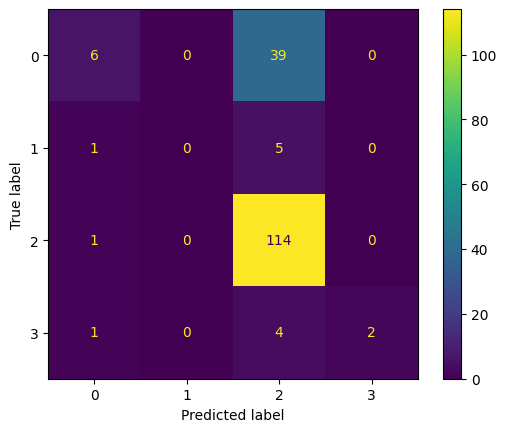

In [74]:
predictions = knn.predict(x_test)
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, predictions, labels=knn.classes_)
confusion_matrix
cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=knn.classes_)
cm_display.plot()
plt.show()


We per usual, we can use a confusion matrix the visualize the accuracy of the model at an abstracted level, but it is difficult to visualize the inner workings of the algorithm at a multidinesional level. Let's try to use dimensionality reduction to get a better look at the performance.

## PCA Dimensionality Reduction

KNN accuracy with PCA: 0.6127167630057804


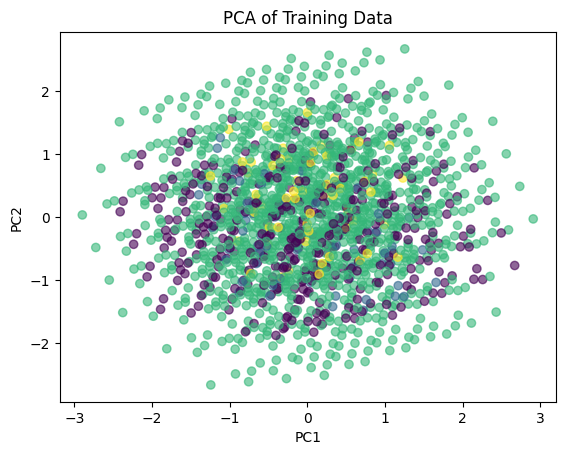

In [37]:
# Reduce dimension to 2 with PCA
pca = make_pipeline(StandardScaler(), PCA(n_components=2))
pca.fit(x_train, y_train) #fit to the pca pipeline
x_train_transformed = pca.transform(x_train) # transform the data using the pca pipeline
# Use a nearest neighbor classifier to evaluate the methods
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(x_train_transformed, y_train)
acc = knn.score(pca.transform(x_test), y_test)
plt.scatter(x_train_transformed[:, 0], x_train_transformed[:, 1], c=y_train, alpha=0.6)
plt.title('PCA of Training Data')
plt.xlabel('PC1')
plt.ylabel('PC2')
print(f"KNN accuracy with PCA: {acc}")

The reason why this PCA is failing is that we are dealing with ordinal data rather than more continuous/quanitative data, which PCA is not suited for. We need to find a better way for dimension reduction for this case.

## A better approach, Linear Discriminant Analysis

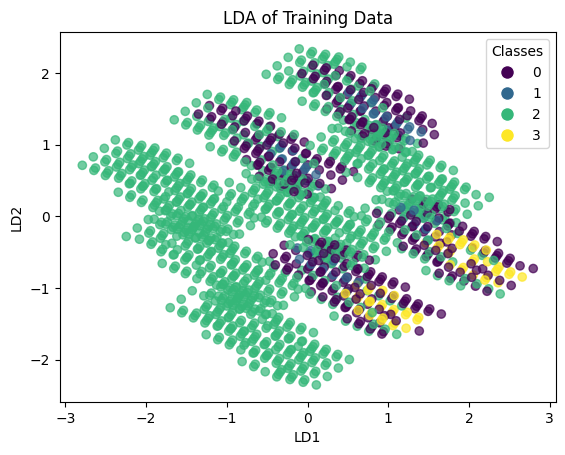

KNN accuracy with LDA: 0.7398843930635838


In [38]:
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=2))
lda.fit(x_train, y_train)  # Fit to the lda pipeline
x_train_transformed = lda.transform(x_train)  # Transform the data using the lda pipeline
x_test_transformed = lda.transform(x_test)  # Transform also

# Use a nearest neighbor classifier to evaluate the methods
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(x_train_transformed, y_train)
acc = knn.score(x_test_transformed, y_test)

# Scatter plot with custom legend
# Create colormap
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(y_train.min(), y_train.max())

# Create scatter plot
sc = plt.scatter(x_train_transformed[:, 0], x_train_transformed[:, 1], c=y_train, cmap=cmap, alpha=0.7)

# Create a custom legend
unique_labels = np.unique(y_train)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(label)), markersize=10) 
           for label in unique_labels]
plt.legend(handles, unique_labels, title="Classes", loc="best")

plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('LDA of Training Data')
plt.show()

print(f"KNN accuracy with LDA: {acc}")

As one can see, the data is much more separated by class using LDA. LDA is better suited for classification problems and supervised learning like KNN, making it a better choice than PCA in the case of KNN with a qualitiative ordinal data set.